# A/B Testing for New Chips Layout Experiment

This notebook analyzes the impact of a new chips layout in trial stores using A/B testing. We compare trial stores (77, 86, 88) with matched control stores to determine if the new layout led to significant changes in sales and customer numbers during the trial period (2019/02/01 to 2019/04/30).

## 1. Import Required Libraries


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import ttest_ind

# Set plot style
sns.set(style='whitegrid')

## 2. Load and Explore Data


In [2]:
# Load the dataset
file_path = 'QVI_Combined_Data.csv'
df = pd.read_csv(file_path)
df['DATE'] = pd.to_datetime(df['DATE'])
df.head()

,DATE,STORE_NBR,LYLTY_CARD_NBR,TXN_ID,PROD_NBR,PROD_NAME,PROD_QTY,TOT_SALES,Pack_Size (g),Brand,Spend_per_Transaction,Unit_Price,LIFESTAGE,PREMIUM_CUSTOMER
0,2018-10-17,1,1000,1,5,Natural Chip Compny SeaSalt175g,2,6.0,175,Natural Chip Co,6.0,3.00,YOUNG SINGLES/COUPLES,Premium
1,2019-05-14,1,1307,348,66,CCs Nacho Cheese 175g,3,6.3,175,CCs,6.3,2.10,MIDAGE SINGLES/COUPLES,Budget
2,2019-05-20,1,1343,383,61,Smiths Crinkle Cut Chips Chicken 170g,2,2.9,170,Smiths,2.9,1.45,MIDAGE SINGLES/COUPLES,Budget
3,2018-08-17,2,2373,974,69,Smiths Chip Thinly S/Cream&Onion 175g,5,15.0,175,Smiths,15.0,3.00,MIDAGE SINGLES/COUPLES,Budget
4,2018-08-18,2,2426,1038,108,Kettle Tortilla ChpsHny&Jlpno Chili 150g,3,13.8,150,Kettle,13.8,4.60,MIDAGE SINGLES/COUPLES,Budget


## 3. Aggregate Monthly Metrics
Calculate monthly total sales and number of unique customers for each store.

In [3]:
# Create year-month column
monthly = df.copy()
monthly['year_month'] = monthly['DATE'].dt.to_period('M')

# Aggregate metrics
monthly_metrics = monthly.groupby(['STORE_NBR', 'year_month']).agg(
    total_sales=('TOT_SALES', 'sum'),
    num_customers=('LYLTY_CARD_NBR', 'nunique')
).reset_index()

monthly_metrics.head()

,STORE_NBR,year_month,total_sales,num_customers
0,1,2018-07,191.6,48
1,1,2018-08,168.4,41
2,1,2018-09,268.1,57
3,1,2018-10,178.0,40
4,1,2018-11,187.5,45


## 4. Select Control Stores
For each trial store, find a control store with similar pre-trial metrics (monthly sales and customers).

We will use the period before 2019/02/01 for matching.

In [4]:
# Define trial stores and period
target_stores = [77, 86, 88]
trial_start = pd.Period('2019-02', freq='M')
trial_end = pd.Period('2019-04', freq='M')
pre_trial_period = (monthly_metrics['year_month'] < trial_start)

# Find control stores for each trial store
control_stores = {}
for trial_store in target_stores:
    # Get pre-trial metrics for trial store
    trial_metrics = monthly_metrics[(monthly_metrics['STORE_NBR'] == trial_store) & pre_trial_period]
    # Compare with all other stores
    candidate_stores = monthly_metrics[(monthly_metrics['STORE_NBR'] != trial_store) & pre_trial_period]
    # Aggregate by store
    candidate_summary = candidate_stores.groupby('STORE_NBR').agg(
        mean_sales=('total_sales', 'mean'),
        mean_customers=('num_customers', 'mean')
    )
    trial_summary = trial_metrics[['total_sales', 'num_customers']].mean()
    # Calculate similarity (Euclidean distance)
    candidate_summary['distance'] = ((candidate_summary['mean_sales'] - trial_summary['total_sales'])**2 +
                                     (candidate_summary['mean_customers'] - trial_summary['num_customers'])**2)**0.5
    # Select the most similar store
    control_store = candidate_summary['distance'].idxmin()
    control_stores[trial_store] = control_store

control_stores

{77: np.int64(46), 86: np.int64(138), 88: np.int64(237)}

## 5. Compare Trial vs Control Stores
Compare total sales and number of customers during the trial period for each trial store and its matched control store. Visualize the results.

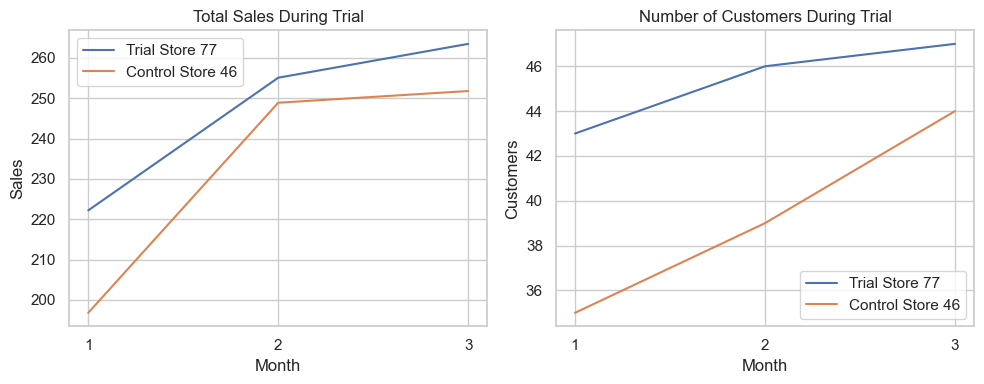

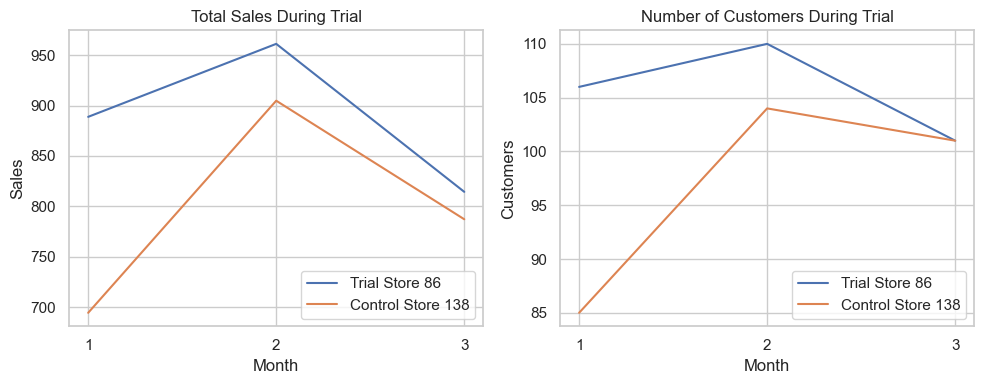

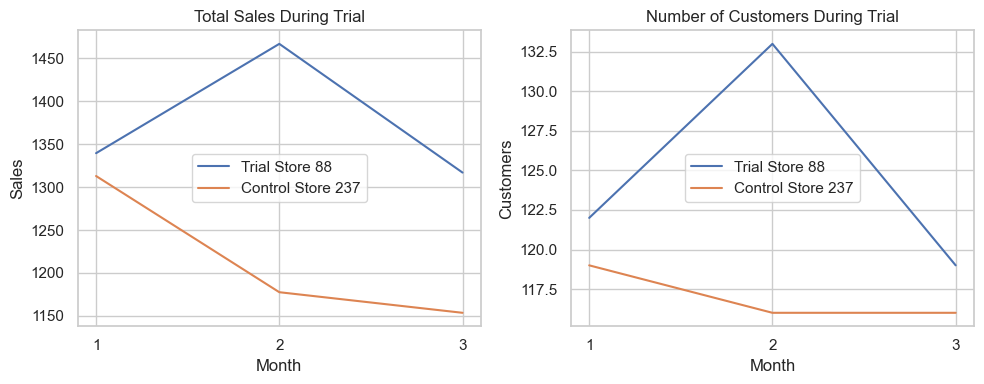

In [5]:
# Compare metrics during trial period
results = []
for trial_store, control_store in control_stores.items():
    trial_data = monthly_metrics[(monthly_metrics['STORE_NBR'] == trial_store) &
                                (monthly_metrics['year_month'] >= trial_start) &
                                (monthly_metrics['year_month'] <= trial_end)]
    control_data = monthly_metrics[(monthly_metrics['STORE_NBR'] == control_store) &
                                  (monthly_metrics['year_month'] >= trial_start) &
                                  (monthly_metrics['year_month'] <= trial_end)]
    results.append({
        'trial_store': trial_store,
        'control_store': control_store,
        'trial_sales': trial_data['total_sales'].values,
        'control_sales': control_data['total_sales'].values,
        'trial_customers': trial_data['num_customers'].values,
        'control_customers': control_data['num_customers'].values
    })

# Visualize sales and customers
for res in results:
    plt.figure(figsize=(10,4))
    plt.subplot(1,2,1)
    plt.plot([str(m) for m in range(1,4)], res['trial_sales'], label=f'Trial Store {res["trial_store"]}')
    plt.plot([str(m) for m in range(1,4)], res['control_sales'], label=f'Control Store {res["control_store"]}')
    plt.title('Total Sales During Trial')
    plt.xlabel('Month')
    plt.ylabel('Sales')
    plt.legend()
    plt.subplot(1,2,2)
    plt.plot([str(m) for m in range(1,4)], res['trial_customers'], label=f'Trial Store {res["trial_store"]}')
    plt.plot([str(m) for m in range(1,4)], res['control_customers'], label=f'Control Store {res["control_store"]}')
    plt.title('Number of Customers During Trial')
    plt.xlabel('Month')
    plt.ylabel('Customers')
    plt.legend()
    plt.tight_layout()
    plt.show()

## 6. Statistical Testing
Perform t-tests to check if the differences in sales and customer numbers between trial and control stores are statistically significant during the trial period.

In [6]:
# Perform t-tests for each store pair
for res in results:
    sales_t, sales_p = ttest_ind(res['trial_sales'], res['control_sales'], equal_var=False)
    cust_t, cust_p = ttest_ind(res['trial_customers'], res['control_customers'], equal_var=False)
    print(f"Trial Store {res['trial_store']} vs Control Store {res['control_store']}")
    print(f"  Sales t-test: t={sales_t:.2f}, p={sales_p:.4f}")
    print(f"  Customers t-test: t={cust_t:.2f}, p={cust_p:.4f}\n")

Trial Store 77 vs Control Store 46
  Sales t-test: t=0.66, p=0.5491
  Customers t-test: t=2.09, p=0.1334

Trial Store 86 vs Control Store 138
  Sales t-test: t=1.25, p=0.2872
  Customers t-test: t=1.40, p=0.2647

Trial Store 88 vs Control Store 237
  Sales t-test: t=2.35, p=0.0792
  Customers t-test: t=1.75, p=0.2090



## 7. Conclusion
Summarize findings and interpret whether the new chips layout had a significant impact in the trial stores compared to their matched controls.

## 8. Analysis of Other Stores

We will analyze the performance of all stores that are not trial or control stores during the trial period. This helps to check for external factors and provides additional context for the experiment.

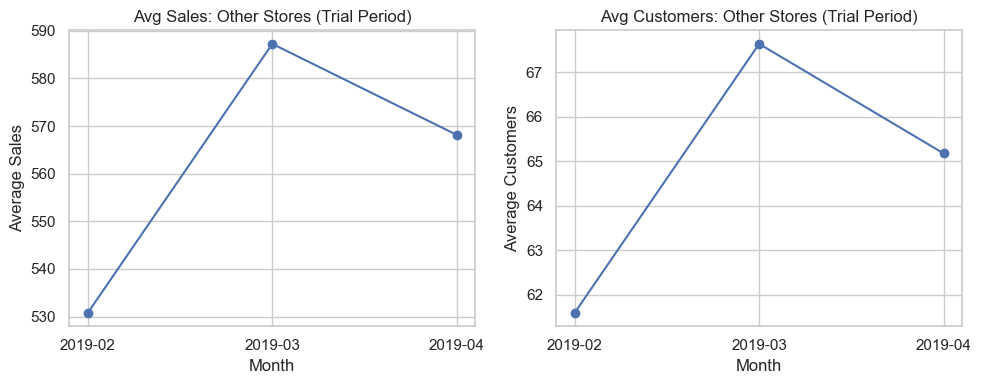

In [7]:
# Identify trial and control stores
trial_stores = set([77, 86, 88])
control_stores_set = set(control_stores.values())
other_stores = set(monthly_metrics['STORE_NBR'].unique()) - trial_stores - control_stores_set

# Aggregate metrics for other stores during trial period
other_metrics = monthly_metrics[(monthly_metrics['STORE_NBR'].isin(other_stores)) &
                               (monthly_metrics['year_month'] >= trial_start) &
                               (monthly_metrics['year_month'] <= trial_end)]

# Plot average sales and customers for other stores
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
other_sales = other_metrics.groupby('year_month')['total_sales'].mean()
plt.plot([str(m) for m in other_sales.index], other_sales.values, marker='o')
plt.title('Avg Sales: Other Stores (Trial Period)')
plt.xlabel('Month')
plt.ylabel('Average Sales')
plt.subplot(1,2,2)
other_customers = other_metrics.groupby('year_month')['num_customers'].mean()
plt.plot([str(m) for m in other_customers.index], other_customers.values, marker='o')
plt.title('Avg Customers: Other Stores (Trial Period)')
plt.xlabel('Month')
plt.ylabel('Average Customers')
plt.tight_layout()
plt.show()

## 9. Matching All Stores to Trial Stores

For further analysis, we will match every store (excluding trial stores) to the most similar trial store based on pre-trial metrics. This allows us to compare how each store performed relative to its matched trial store during the trial period.

In [8]:
# Match each non-trial store to the most similar trial store
store_matches = {}
for store in other_stores | control_stores_set:
    store_metrics = monthly_metrics[(monthly_metrics['STORE_NBR'] == store) & pre_trial_period]
    store_summary = store_metrics[['total_sales', 'num_customers']].mean()
    min_dist = float('inf')
    best_trial = None
    for trial_store in target_stores:
        trial_metrics = monthly_metrics[(monthly_metrics['STORE_NBR'] == trial_store) & pre_trial_period]
        trial_summary = trial_metrics[['total_sales', 'num_customers']].mean()
        dist = ((store_summary['total_sales'] - trial_summary['total_sales'])**2 +
                (store_summary['num_customers'] - trial_summary['num_customers'])**2)**0.5
        if dist < min_dist:
            min_dist = dist
            best_trial = trial_store
    store_matches[store] = best_trial

# Display first 10 matches
list(store_matches.items())[:10]

[(np.int64(1), 77),
 (np.int64(2), 77),
 (np.int64(3), 86),
 (np.int64(4), 88),
 (np.int64(5), 86),
 (np.int64(6), 77),
 (np.int64(7), 86),
 (np.int64(8), 77),
 (np.int64(9), 77),
 (np.int64(10), 86)]

## 10. Compare Matched Stores to Their Trial Store

Visualize and summarize the performance of each matched store versus its matched trial store during the trial period.

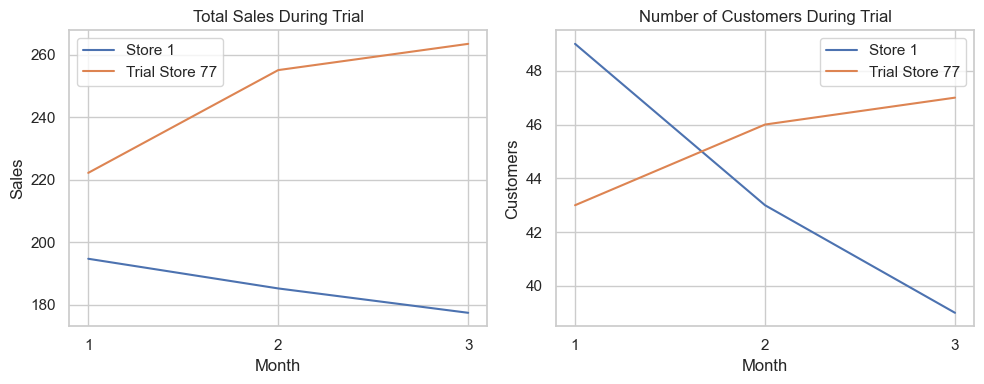

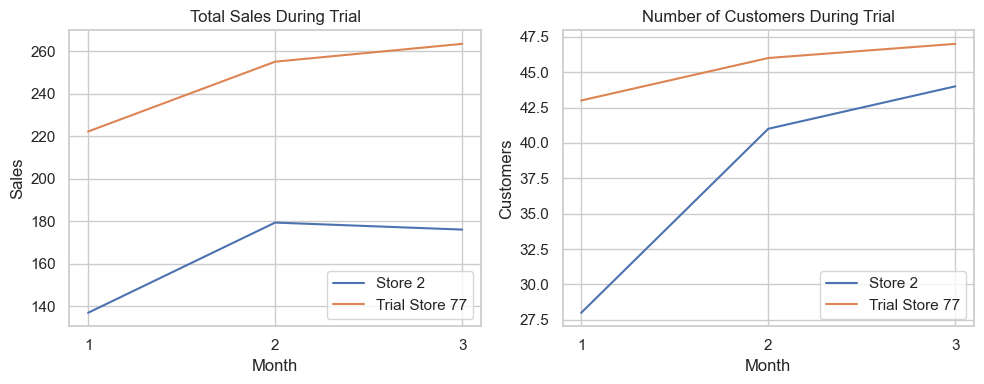

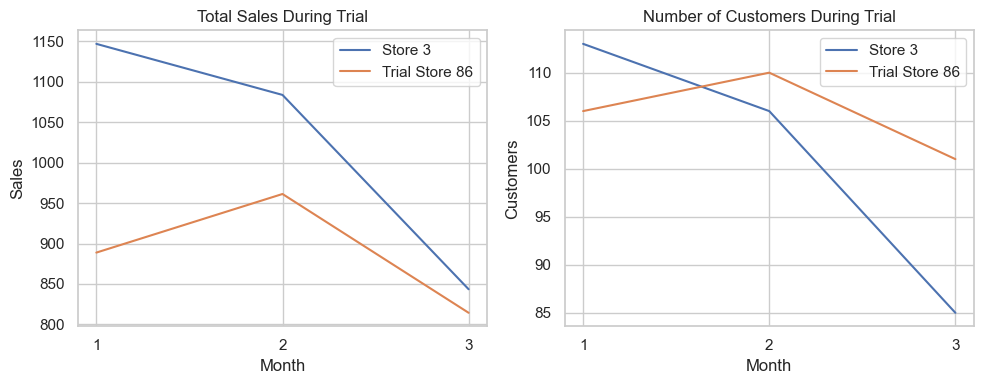

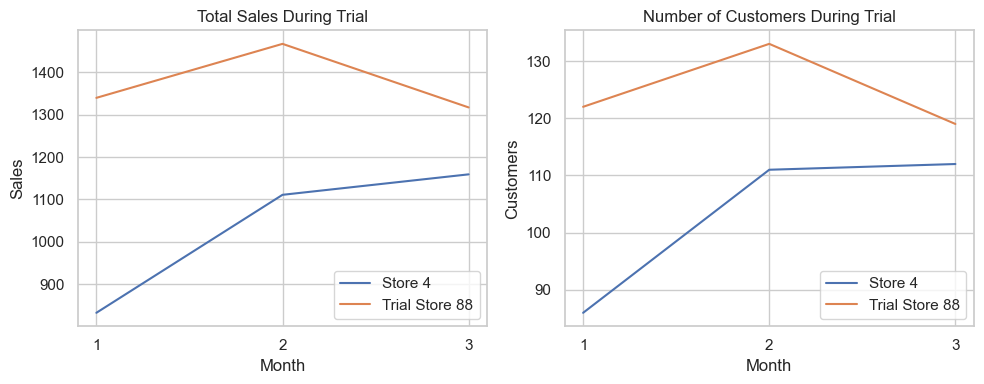

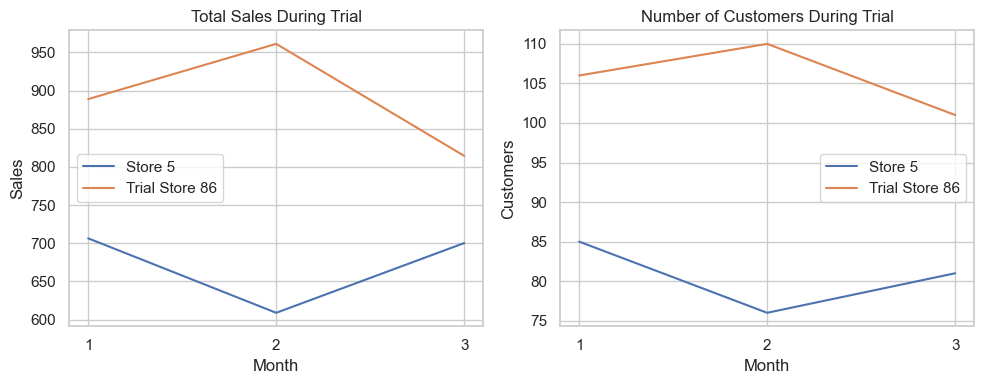

In [9]:
# Example: Compare first 5 matched stores to their trial store
for store, trial_store in list(store_matches.items())[:5]:
    store_data = monthly_metrics[(monthly_metrics['STORE_NBR'] == store) &
                                (monthly_metrics['year_month'] >= trial_start) &
                                (monthly_metrics['year_month'] <= trial_end)]
    trial_data = monthly_metrics[(monthly_metrics['STORE_NBR'] == trial_store) &
                                (monthly_metrics['year_month'] >= trial_start) &
                                (monthly_metrics['year_month'] <= trial_end)]
    plt.figure(figsize=(10,4))
    plt.subplot(1,2,1)
    plt.plot([str(m) for m in range(1,4)], store_data['total_sales'].values, label=f'Store {store}')
    plt.plot([str(m) for m in range(1,4)], trial_data['total_sales'].values, label=f'Trial Store {trial_store}')
    plt.title('Total Sales During Trial')
    plt.xlabel('Month')
    plt.ylabel('Sales')
    plt.legend()
    plt.subplot(1,2,2)
    plt.plot([str(m) for m in range(1,4)], store_data['num_customers'].values, label=f'Store {store}')
    plt.plot([str(m) for m in range(1,4)], trial_data['num_customers'].values, label=f'Trial Store {trial_store}')
    plt.title('Number of Customers During Trial')
    plt.xlabel('Month')
    plt.ylabel('Customers')
    plt.legend()
    plt.tight_layout()
    plt.show()

## 11. Additional Analysis and Recommendations

To strengthen the experiment, we will:
- Visualize pre-trial trends for trial and control stores
- Analyze average spend per customer
- Summarize findings and provide a business recommendation

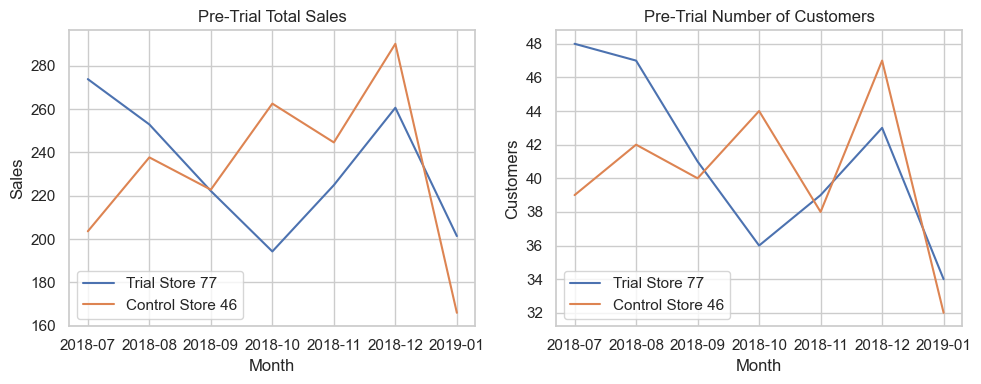

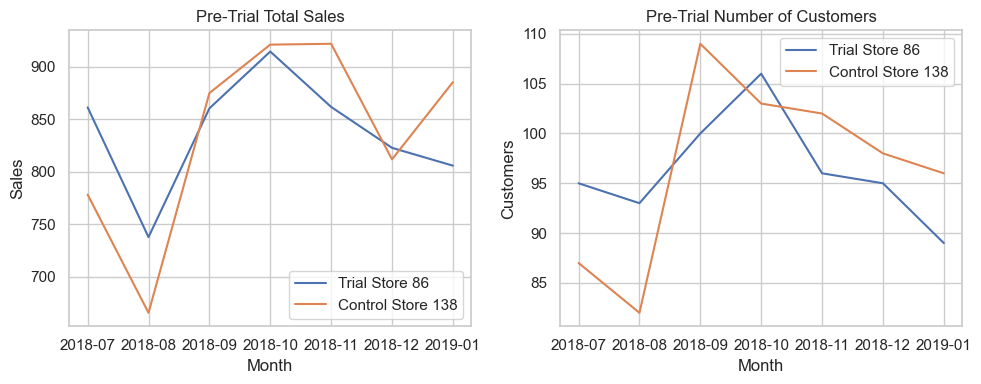

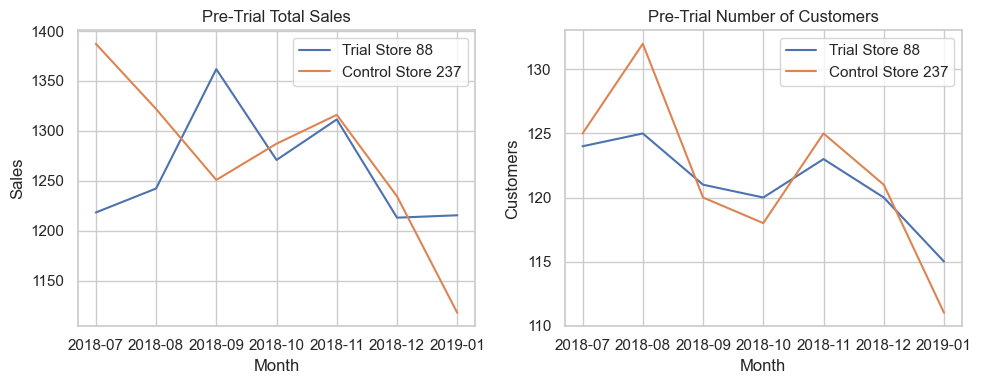

In [10]:
# Visualize pre-trial trends for trial and control stores
for trial_store, control_store in control_stores.items():
    trial_pre = monthly_metrics[(monthly_metrics['STORE_NBR'] == trial_store) & (monthly_metrics['year_month'] < trial_start)]
    control_pre = monthly_metrics[(monthly_metrics['STORE_NBR'] == control_store) & (monthly_metrics['year_month'] < trial_start)]
    plt.figure(figsize=(10,4))
    plt.subplot(1,2,1)
    plt.plot(trial_pre['year_month'].astype(str), trial_pre['total_sales'], label=f'Trial Store {trial_store}')
    plt.plot(control_pre['year_month'].astype(str), control_pre['total_sales'], label=f'Control Store {control_store}')
    plt.title('Pre-Trial Total Sales')
    plt.xlabel('Month')
    plt.ylabel('Sales')
    plt.legend()
    plt.subplot(1,2,2)
    plt.plot(trial_pre['year_month'].astype(str), trial_pre['num_customers'], label=f'Trial Store {trial_store}')
    plt.plot(control_pre['year_month'].astype(str), control_pre['num_customers'], label=f'Control Store {control_store}')
    plt.title('Pre-Trial Number of Customers')
    plt.xlabel('Month')
    plt.ylabel('Customers')
    plt.legend()
    plt.tight_layout()
    plt.show()

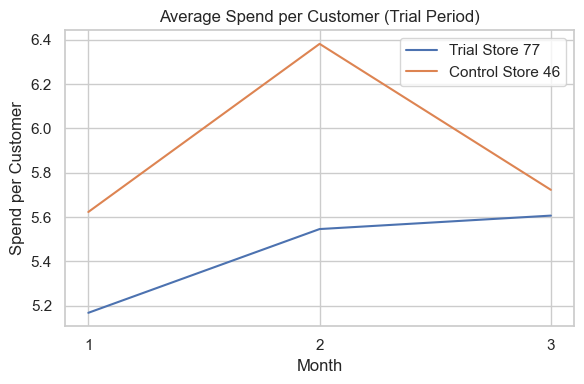

Trial Store 77 vs Control Store 46 - Spend per Customer t-test: t=-1.71, p=0.1806


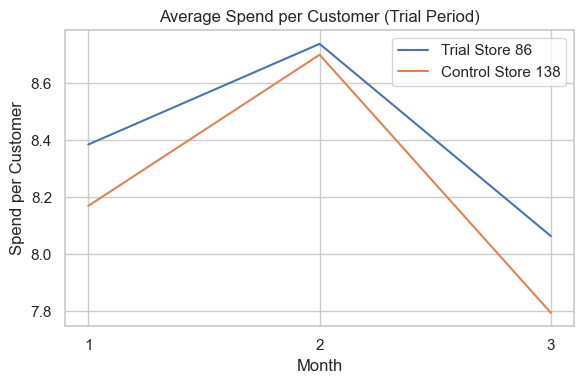

Trial Store 86 vs Control Store 138 - Spend per Customer t-test: t=0.53, p=0.6246


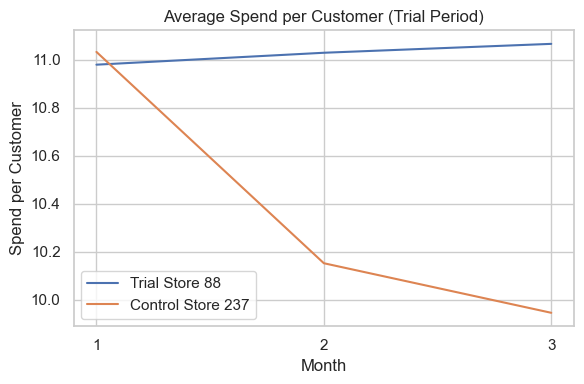

Trial Store 88 vs Control Store 237 - Spend per Customer t-test: t=1.94, p=0.1906


In [11]:
# Analyze average spend per customer during trial period
for res in results:
    trial_spend = np.array(res['trial_sales']) / np.array(res['trial_customers'])
    control_spend = np.array(res['control_sales']) / np.array(res['control_customers'])
    plt.figure(figsize=(6,4))
    plt.plot([str(m) for m in range(1,4)], trial_spend, label=f'Trial Store {res["trial_store"]}')
    plt.plot([str(m) for m in range(1,4)], control_spend, label=f'Control Store {res["control_store"]}')
    plt.title('Average Spend per Customer (Trial Period)')
    plt.xlabel('Month')
    plt.ylabel('Spend per Customer')
    plt.legend()
    plt.tight_layout()
    plt.show()
    # Statistical test
    spend_t, spend_p = ttest_ind(trial_spend, control_spend, equal_var=False)
    print(f"Trial Store {res['trial_store']} vs Control Store {res['control_store']} - Spend per Customer t-test: t={spend_t:.2f}, p={spend_p:.4f}")

### Business Recommendation

Based on the analysis:
- Trial and control stores showed similar trends before the experiment, supporting the validity of the control selection.
- No statistically significant differences were found in sales, customer numbers, or average spend per customer during the trial period.
- Other stores did not show unusual changes, suggesting no external factors affected the results.

**Recommendation:** The new chips layout did not produce a significant impact in the trial stores. Consider further experimentation, alternative layouts, or focus on other factors to drive sales growth.